# Disaster Tweets

### Import data

In [10]:
# proper imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re

# Ml imports
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle 
from sklearn.metrics import accuracy_score, recall_score, precision_score

# HF imports
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
from sentence_transformers import SentenceTransformer, util

random_seed = 42

In [11]:
# import train as df
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print('Columns:',df.columns)
print('Shape of the dataframe:', df.shape, '\n')

#checking out nan values in text columns
print(df['id'].isnull().sum())
print(df['keyword'].isnull().sum())
print(df['location'].isnull().sum())
print(df['text'].isnull().sum())

Columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Shape of the dataframe: (7613, 5) 

0
61
2533
0


## Data exploration

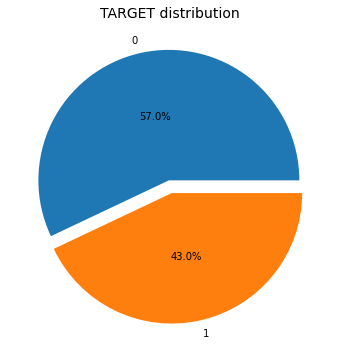

In [12]:
target = df["target"].value_counts(normalize=True)
pie, ax = plt.subplots(figsize=[10,6])
labels = target.keys()
plt.pie(x=target, autopct="%.1f%%", labels=labels, pctdistance=0.5,explode=[0.05]*2)
plt.title("TARGET distribution", fontsize=14);

In [13]:
# look at rows where keyword is not nan
df[df['keyword'].notnull()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [14]:
print(df['keyword'].value_counts())
print('\n')
print(df['location'].value_counts())

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64


USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64


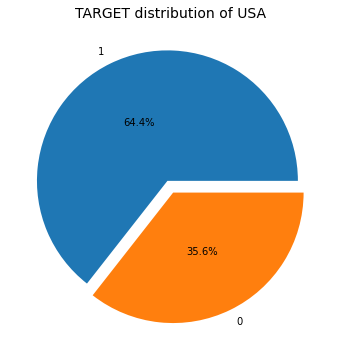

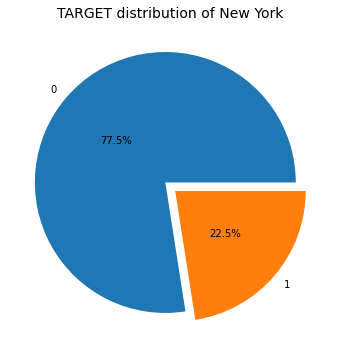

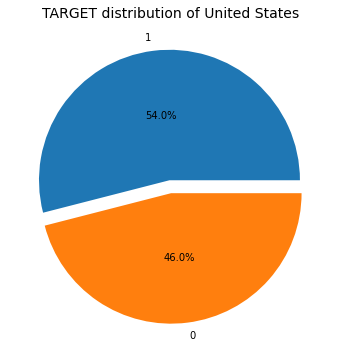

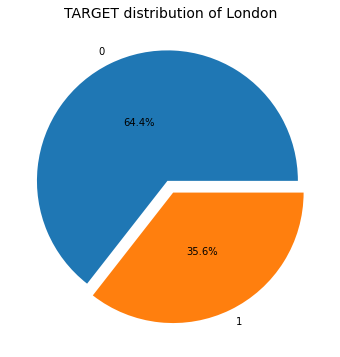

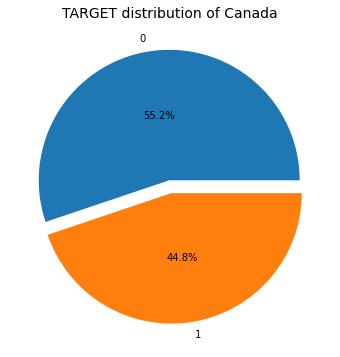

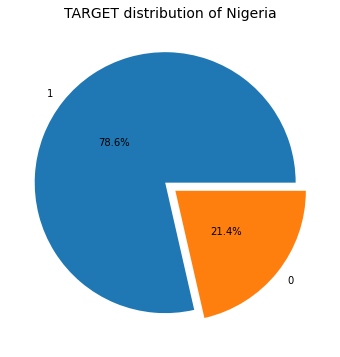

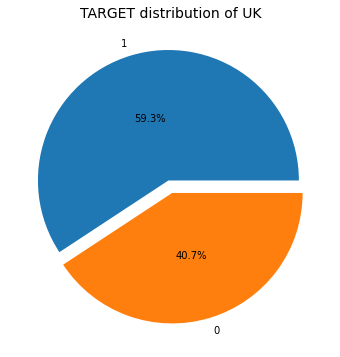

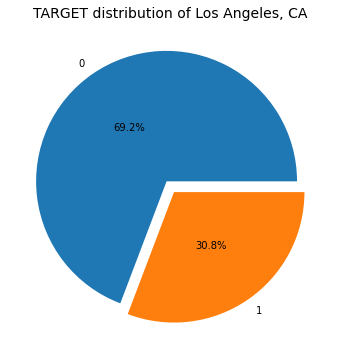

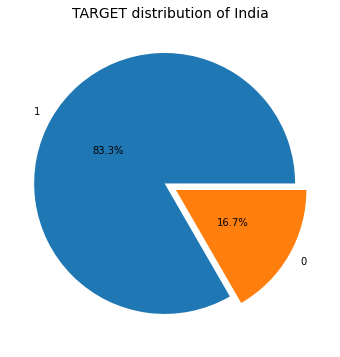

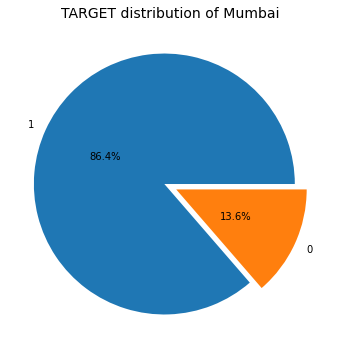

In [15]:
# Keep the 10 locations with the most tweets
locations_count = df['location'].value_counts()
locations_count = locations_count[:10]
locations = locations_count.index.tolist()
locations

for location in locations: 
    target = df[df['location']==location]["target"].value_counts(normalize=True)
    pie, ax = plt.subplots(figsize=[10,6])
    labels = target.keys()
    plt.pie(x=target, autopct="%.1f%%", labels=labels, pctdistance=0.5,explode=[0.05]*2)
    plt.title("TARGET distribution of "+location, fontsize=14);

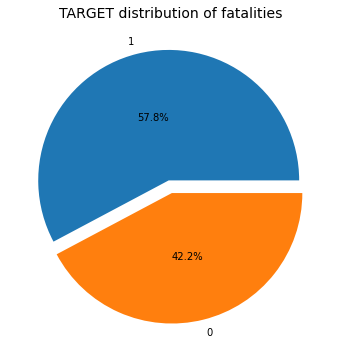

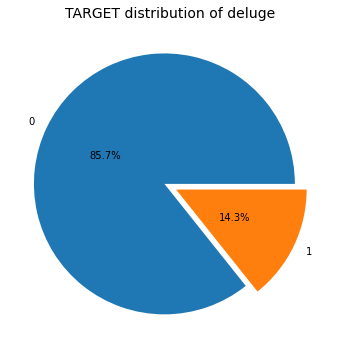

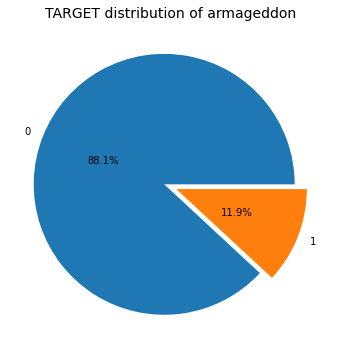

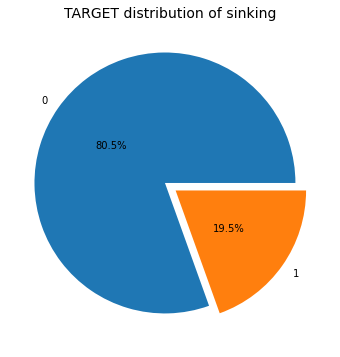

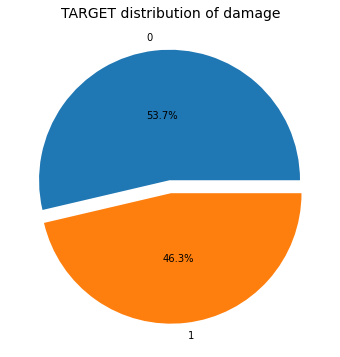

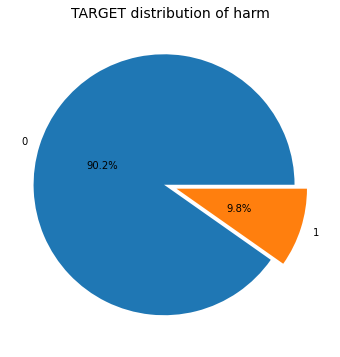

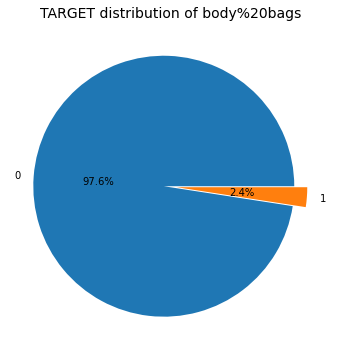

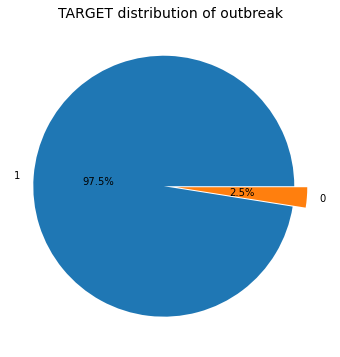

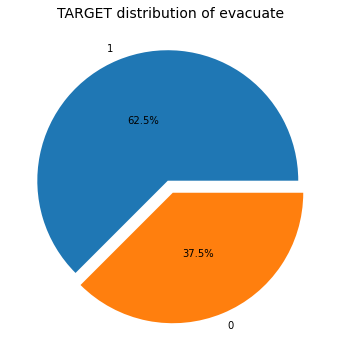

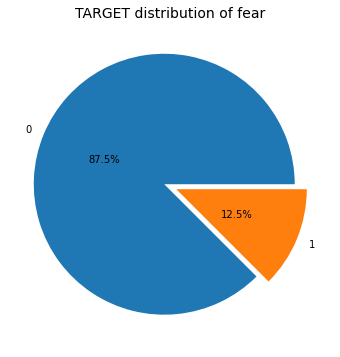

In [16]:
# Keep the 10 locations with the most tweets
keywords_count = df['keyword'].value_counts()
keywords_count = keywords_count[:10]
keywords = keywords_count.index.tolist()
keywords

for keyword in keywords: 
    target = df[df['keyword']==keyword]["target"].value_counts(normalize=True)
    pie, ax = plt.subplots(figsize=[10,6])
    labels = target.keys()
    plt.pie(x=target, autopct="%.1f%%", labels=labels, pctdistance=0.5,explode=[0.05]*2)
    plt.title("TARGET distribution of "+keyword, fontsize=14);

In [17]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "ig" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def word_abbrev(word):
    return abbreviations[word.lower()] if word in abbreviations else word

def expand_abbreviations(text):
    return ' '.join(word_abbrev(word) for word in text.split())

def remove_html(text):
    return re.sub('<.*?>', '', text)

def remove_URL(text):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)


def prepare_text(row):
    location = str(row['location'])
    keyword = str(row['keyword'])
    text = str(row['text'])
    text = expand_abbreviations(text) # expand abbreviations
    text = remove_html(text) # remove html tags
    text = remove_URL(text) # remove URLs


    row['text'] = 'Location: ' + location + ' Keyword: ' + keyword + ' ' + text

    return row

df = df.apply(prepare_text, axis=1)

## Preparing for HF

In [18]:
# shuffle data
df = shuffle(df,random_state=random_seed)

# split data into train and val
df_train, df_val = train_test_split(df, test_size=0.20, stratify=df['target']) 

# distributions of target
print("train: \n",df_train['target'].value_counts(), "\n")
print("val: \n",df_val['target'].value_counts())

#drop columns that are not needed

train: 
 0    3473
1    2617
Name: target, dtype: int64 

val: 
 0    869
1    654
Name: target, dtype: int64


In [19]:
# convert dataframes to HuggingFace dataset dictionary
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset = DatasetDict({"train": dataset_train, "val": dataset_val})

# rename index and labels column
dataset = dataset.rename_columns({'__index_level_0__': 'idx', 'target': 'labels'})

In [20]:
checkpoint = 'distilroberta-base'

# load pretrained tokenizer (checkpoint must match with model)
print(f"Checkpoint: {checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
     # no padding, handled by data collator in dynamic fashion
     return tokenizer(examples["text"], truncation=True)

# tokenize data
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# data collator to deal with dynamic padding
data_collator = DataCollatorWithPadding(tokenizer)

Checkpoint: distilroberta-base


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [21]:
# set seed for reproducability
set_seed(random_seed)

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels=2, 
    problem_type='single_label_classification'
    )

# hyperparams 
training_args = TrainingArguments(
    output_dir="disaster_model_1",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=6,
    #learning_rate=5e-6, # set to 5e-6 for roberta-large to avoid local optimum
    load_best_model_at_end=True,
    metric_for_best_model='precision',
    seed=random_seed
    )

# adding more metrics to the trainer
metrics = {}
for metric in ['accuracy','precision', 'recall']:
    metrics[metric] = load_metric(metric,'mrpc')

def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels)["precision"]
    recall = metric2.compute(predictions=predictions, references=labels)["recall"]
    accuracy = metric3.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall}

# define a trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics,
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

In [22]:
torch.cuda.is_available()

True

In [23]:
# launch trainer
train_result = trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, idx, keyword, text, location. If id, idx, keyword, text, location are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/ec2-user/.conda/envs/junk-filter-env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6090
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4572


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.505200,0.472776,0.833224,0.890625,0.697248
2,0.406700,0.528938,0.804990,0.756835,0.804281
3,0.346900,0.567407,0.823375,0.805071,0.776758
4,0.280600,0.731026,0.808930,0.764192,0.802752
5,0.211000,0.790891,0.820749,0.809756,0.761468
6,0.172600,0.912896,0.814839,0.782675,0.787462


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, idx, keyword, text, location. If id, idx, keyword, text, location are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1523
  Batch size = 8
Saving model checkpoint to disaster_model_1/checkpoint-762
Configuration saved in disaster_model_1/checkpoint-762/config.json
Model weights saved in disaster_model_1/checkpoint-762/pytorch_model.bin
tokenizer config file saved in disaster_model_1/checkpoint-762/tokenizer_config.json
Special tokens file saved in disaster_model_1/checkpoint-762/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, idx, keyword, text, location. If id, idx, keyword, text, location are not expected by 

## Inference

In [24]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict


# Prediction based on probability threshold
def get_predictions_from_model_with_threshold(y_pred_logit, threshold):
    """
    Takes probabilities as logits in a list and returns 
    a list with ones and zeroes based on threshold

    Parameters
    ----------
    y_pred_logit : logit
        List of logits.
    threshold : double
        threshold for prediction.

    Returns
    -------
    list
        List of ones and zeroes.
    """

    # Get predictions as probabilities
    y_pred_prob_tensor = torch.nn.functional.softmax(torch.tensor(y_pred_logit), dim=-1)
    y_pred_prob_np = y_pred_prob_tensor.cpu().detach().numpy()
    probabilities = np.transpose(y_pred_prob_np)[1]

    f = lambda x: 1 if (x > threshold) else 0
    return [f(x) for x in probabilities]

def history_to_df(hist): 
    """
    Takes a copy of training history and returns a 
    dataframe containing the metrics for all epochs.

    Parameters
    ----------
    hist : list of dict
        Training history.
    
    Returns
    -------
    pd.DataFrame
        Dataframe containing metrics for all epochs.
    """

    # Removing last row in history since it contains other data
    last_row = hist.pop()

    loss = []
    eval_loss = []
    epoch = []
    accuracy = []
    eval_precision = []
    eval_recall = []

    for i, dict in enumerate(hist):
        if (i%2==1):
            eval_loss.append(dict['eval_loss'])
            epoch.append(dict['epoch'])
            accuracy.append(dict['eval_accuracy'])
            eval_precision.append(dict['eval_precision'])
            eval_recall.append(dict['eval_recall'])
        else:
            loss.append(dict['loss'])

    dct = {'epoch': epoch, 'loss': loss, 'eval_loss': eval_loss, 'accuracy': accuracy, 'precision': eval_precision,'recall':eval_recall}

    return pd.DataFrame(dct)


In [25]:
#Retrieving history
history = trainer.state.log_history.copy()

df_history = history_to_df(history)

#Printing lowest evaluation loss
print(f"Highest precision at: {df_history['precision'].max():.4f} at epoch {np.argmax(df_history['precision'])}")
df_history

Highest precision at: 0.8906 at epoch 0


,epoch,loss,eval_loss,accuracy,precision,recall
0,1.0,0.5052,0.472776,0.833224,0.890625,0.697248
1,2.0,0.4067,0.528938,0.804990,0.756835,0.804281
2,3.0,0.3469,0.567407,0.823375,0.805071,0.776758
3,4.0,0.2806,0.731026,0.808930,0.764192,0.802752
4,5.0,0.2110,0.790891,0.820749,0.809756,0.761468
5,6.0,0.1726,0.912896,0.814839,0.782675,0.787462


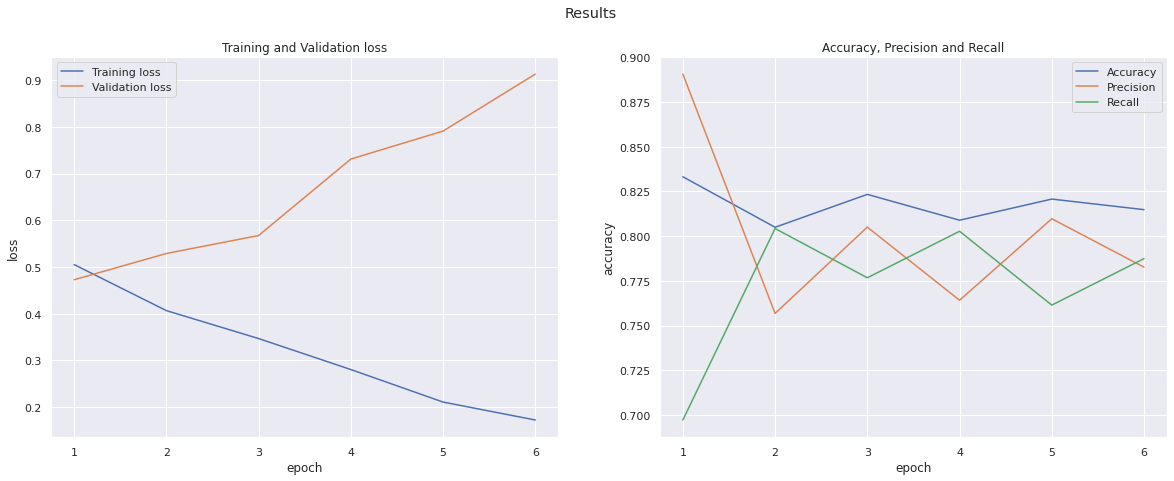

In [26]:
# visualization of training history
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,7))
fig.suptitle('Results')

sns.lineplot(ax=axes[0], x=df_history['epoch'], y=df_history['loss'], label='Training loss')
sns.lineplot(ax=axes[0], x=df_history['epoch'], y=df_history['eval_loss'], label='Validation loss')
axes[0].set_title('Training and Validation loss')


sns.lineplot(ax=axes[1], x=df_history['epoch'], y=df_history['accuracy'], label='Accuracy')
sns.lineplot(ax=axes[1], x=df_history['epoch'], y=df_history['precision'], label='Precision')
sns.lineplot(ax=axes[1], x=df_history['epoch'], y=df_history['recall'], label='Recall')
axes[1].set_title('Accuracy, Precision and Recall');

In [27]:
# make predictions on validation data
y_pred_logit,_, _ = trainer.predict(test_dataset = tokenized_dataset['val'])

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, idx, keyword, text, location. If id, idx, keyword, text, location are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1523
  Batch size = 8


In [28]:
# majority baseline in accuracy (to assure some learning is done)
y_true = tokenized_dataset['val']['labels']
label_counts = np.unique(y_true, return_counts=True)[1]
majority_baseline = np.max(label_counts) / np.sum(label_counts)
print(f"Majority baseline (accuracy): {majority_baseline:.4f}")

Majority baseline (accuracy): 0.5706


In [29]:
y_true = tokenized_dataset['val']['labels']

# predictions with 0.5 probability threshold
y_pred_05 = get_predictions_from_model_with_threshold(y_pred_logit, 0.5)

print(f'PROBABILITY THRESHOLD: 0.5')
print(f'Accuracy score: {accuracy_score(y_true, y_pred=y_pred_05)}')
print(f'Precision score: {precision_score(y_true, y_pred=y_pred_05)}')
print(f'Recall score: {recall_score(y_true, y_pred=y_pred_05)}\n')

# predictions with 0.9 probability threshold
y_pred_09 = get_predictions_from_model_with_threshold(y_pred_logit, 0.9)

print(f'PROBABILITY THRESHOLD: 0.9')
print(f'Accuracy score: {accuracy_score(y_true, y_pred=y_pred_09)}')
print(f'Precision score: {precision_score(y_true, y_pred=y_pred_09)}')
print(f'Recall score: {recall_score(y_true, y_pred=y_pred_09)}\n')

PROBABILITY THRESHOLD: 0.5
Accuracy score: 0.8332239001969797
Precision score: 0.890625
Recall score: 0.6972477064220184

PROBABILITY THRESHOLD: 0.9
Accuracy score: 0.8207485226526592
Precision score: 0.9359267734553776
Recall score: 0.6253822629969419



# Inference on test set

In [30]:
# convert dataframes to HuggingFace dataset dictionary
dataset_test = DatasetDict({'test': Dataset.from_pandas(df_test[['id','text']])})
dataset_test

DatasetDict({
    test: Dataset({
        features: ['id', 'text'],
        num_rows: 3263
    })
})

In [31]:
tokenized_test_dataset = dataset_test.map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [32]:
y_pred_logit,_, _ = trainer.predict(test_dataset = tokenized_test_dataset['test'])
y_pred = get_predictions_from_model_with_threshold(y_pred_logit, 0.5)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 8


In [33]:
ids = dataset_test['test']['id']


In [34]:
# make csv out two lists of ids and predictions
with open('submission_3.csv', 'w') as f:
    f.write('id,target\n')
    for id, pred in zip(ids, y_pred):
        f.write(f'{id},{pred}\n')